# WGAN-GP Training


## imports


In [1]:
import numpy as np
import tensorflow as tf
import pickle
from utils.loaders import load_dataset
from models.WGANGP import WGANGP
import matplotlib.pyplot as plt
import os
%matplotlib inline


Masking Test


In [ ]:
""" import cv2
import numpy as np

# Load image, create mask, and draw white circle on mask
image = cv2.imread('data/dataset128/dataset128/55.png')
mask = np.zeros(image.shape, dtype=np.uint8)
mask = cv2.circle(mask, (64, 64), 20, (255,255,255), -1) 

# Mask input image with binary mask
mask = cv2.bitwise_not(mask)
result = cv2.bitwise_and(image, mask)
# Color background white
result[mask==0] = 255 # Optional

cv2.imshow('image', image)
cv2.imshow('mask', mask)
cv2.imshow('result', result)
cv2.waitKey()
cv2.destroyAllWindows() """


In [ ]:
""" import cv2
import os
import numpy as np


def read_path(file_pathname):

    # Traverse all the pictures in the folder
    for filename in os.listdir(file_pathname):
        
        print(filename)  # Print picture name
        a = 44  # Set the initial edge position of the mask area
        img = cv2.imread(file_pathname+'/'+filename)  # Read the picture
        # 255： Generate all white numerical matrix （ If you want to generate a black area block ,
        mask = np.zeros(img.shape, dtype=np.uint8) 
        # Need generation 0 matrix .）
        # The mask area size is 40×40, Let the pixel value of this area be 0（ black ）
        mask[a:a + 40, a:a + 40] = 255
        # cv2.bitwise_and It's about binary data “ And ” operation ,
        mask = cv2.bitwise_not(mask)
        mask_img = cv2.bitwise_and(img, mask)
        mask_img[mask==0] = 255
        # The white area of the mask image is reserved for the image pixels to be processed , The black area is the elimination of the image pixels to be processed
        # Save the image to the specified location
        cv2.imwrite("/Users/leogenot/Desktop/DeepDrawingGeneration-WGAN-GP/data/dataset128masked/"+filename, mask_img)
read_path("/Users/leogenot/Desktop/DeepDrawingGeneration-WGAN-GP/data/dataset128tomask/dataset128") """


In [2]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'dataset128'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode = 'load'  # 'load' #


## data


In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 128


In [4]:
x_train = load_dataset(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)


Found 20000 images belonging to 1 classes.
128


In [5]:
x_train[0][0][0]


array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

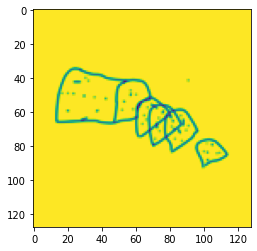

In [6]:
plt.imshow((x_train[0][0][0]))


## architecture


In [7]:
gan = WGANGP(input_dim=(IMAGE_SIZE, IMAGE_SIZE, 1), critic_conv_filters=[128, 256, 512, 1024], critic_conv_kernel_size=[5, 5, 5, 5], critic_conv_strides=[2, 2, 2, 2], critic_batch_norm_momentum=None, critic_activation='leaky_relu', critic_dropout_rate=None, critic_learning_rate=0.0002, generator_initial_dense_layer_size=(8, 8, 512), generator_upsample=[1, 1, 1, 1], generator_conv_filters=[512, 256, 128, 1], generator_conv_kernel_size=[5, 5, 5, 5], generator_conv_strides=[2, 2, 2, 2], generator_batch_norm_momentum=0.9, generator_activation='leaky_relu', generator_dropout_rate=None, generator_learning_rate=0.0002, optimiser='adam', grad_weight=10, z_dim=100, batch_size=BATCH_SIZE
             )

if mode == 'build':
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(128, 128, 1)


In [8]:
gan.critic.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 128, 128, 1)]     0         
_________________________________________________________________
critic_conv_0 (Conv2D)       multiple                  3328      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
critic_conv_1 (Conv2D)       multiple                  819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
critic_conv_2 (Conv2D)       multiple                  3277312   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0     

In [9]:
gan.generator.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 16, 16, 512)       6554112   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 512)       2048

## training


In [10]:
EPOCHS = 30001
PRINT_EVERY_N_BATCHES = 500
N_CRITIC = 5
BATCH_SIZE = 16


In [11]:
gan.train(
    x_train, batch_size=BATCH_SIZE, epochs=EPOCHS, run_folder=RUN_FOLDER, print_every_n_batches=PRINT_EVERY_N_BATCHES, n_critic=N_CRITIC, using_generator=True
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0 (5, 1) [D loss: (-9.4)(R -15.6, F 4.3, G 0.2)] [G loss: -3.9]
1 (5, 1) [D loss: (-8.7)(R -7.9, F -2.9, G 0.2)] [G loss: 1.3]
2 (5, 1) [D loss: (-8.5)(R -10.9, F 1.6, G 0.1)] [G loss: -3.2]
3 (5, 1) [D loss: (-10.1)(R -18.0, F 5.1, G 0.3)] [G loss: -4.0]
4 (5, 1) [D loss: (-9.6)(R -6.4, F -5.1, G 0.2)] [G loss: 4.2]
5 (5, 1) [D loss: (-9.7)(R -14.7, F 3.9, G 0.1)] [G loss: -6.2]
6 (5, 1) [D loss: (-7.3)(R -20.1, F 8.7, G 0.4)] [G loss: -5.5]
7 (5, 1) [D loss: (-9.3)(R -11.1, F -0.6, G 0.2)] [G loss: 1.8]
8 (5, 1) [D loss: (-9.0)(R -14.5, F 3.9, G 0.2)] [G loss: -3.3]
9 (5, 1) [D loss: (-9.9)(R -12.6, F 1.2, G 0.1)] [G loss: -2.3]
10 (5, 1) [D loss: (-8.7)(R -11.1, F 1.5, G 0.1)] [G loss: -3.3]
11 (5, 1) [D loss: (-9.4)(R -13.3, F 2.3, G 0.2)] [G loss: -5.5]
12 (5, 1) [D loss: (-8.3)(R -7.5, F -3.2, G 0.2)] [G loss: 0.2]
13 (5, 1) [D loss: (-8.1)(R -13.3, F 3.3, G 0.2)] [G loss: -1.8]
14 (5, 1

In [ ]:
""" fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show() """


Make gif of data


In [ ]:
""" from IPython.display import Image
import imageio
import glob

out_file = 'generated_data.gif'

with imageio.get_writer(out_file, mode='I', duration=0.3) as writer:
    file_names = glob.glob('images_gif/*.png')
    file_names = sorted(file_names)
    last = -1

    for i, file_name in enumerate(file_names):
        animated_image = imageio.imread(file_name)
        writer.append_data(animated_image)

    animated_image = imageio.imread(file_name)
    writer.append_data(animated_image)

Image(open('generated_data.gif', 'rb').read()) """


Generate 1 latent space images

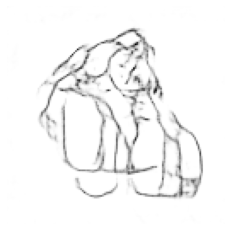

In [1]:
""" # example of loading the generator model and generating images
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import numpy as np

# generate points in latent space as input for the generator


def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# plot the generated images


def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :], cmap="gray")
        ##pyplot.imshow(examples[i, :], cmap="gray")

    pyplot.show()


# load model
model = load_model("generator.h5")
# generate images
latent_points = generate_latent_points(100, 1)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 1)
 """

In [11]:
""" # example of interpolating between generated faces
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from PIL import Image
import PIL
from matplotlib.pyplot import imsave
from matplotlib.pyplot import cm
import io

# generate points in latent space as input for the generator


def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space


def interpolate_points(p1, p2, n_steps=100):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

# create a plot of generated images
size = 128

def plot_generated(examples, n):
    # plot images
    for i in range(n):
        # define subplot
        pyplot.subplot(1, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        img= np.zeros((size,size))
        for j in range(size):
            for k in range(size):
                img[j,k] = examples[i,j,k,0]

        pyplot.imshow(img, 'gray')
        imsave("images_gif/image_%d.png" % i, img)
        Image.open("images_gif/image_%d.png" % i).convert('L').save("images_gif/imageg_%d.png" % i)
        os.remove("images_gif/image_%d.png" % i)


# load model
model = load_model('generator.h5')
# generate points in latent space
pts = generate_latent_points(100, 2)
print(pts.shape)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))
 """


(2, 100)


In [13]:
""" # example of interpolating between generated faces
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from PIL import Image
import PIL
from matplotlib.pyplot import imsave
from matplotlib.pyplot import cm
import io
import imageio

# generate points in latent space as input for the generator


def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space


def interpolate_points(p1, p2, n_steps):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

# create a plot of generated images
size = 128

def plot_generated(examples, n):
    # plot images
    for i in range(n):
        # define subplot
        pyplot.subplot(1, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        img= np.zeros((size,size))
        for j in range(size):
            for k in range(size):
                img[j,k] = examples[i,j,k,0]

        pyplot.imshow(img, 'gray')
        imsave("images_gif/image_%d.png" % i, img)
        Image.open("images_gif/image_%d.png" % i).convert('L').save("images_gif/imageg_%d.png" % i)
        os.remove("images_gif/image_%d.png" % i)


# load model
model = load_model('generator.h5')
# generate points in latent space
pts = generate_latent_points(100, 100)
print(pts.shape)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[99],100)
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))


with imageio.get_writer('gif.gif', mode='I') as writer:
    for i in range (100):
        image = imageio.imread('images_gif/imageg_'+ str(i) + '.png')
        writer.append_data(image) """


(100, 100)


Generate grid latent space images

In [ ]:
""" # example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5) """

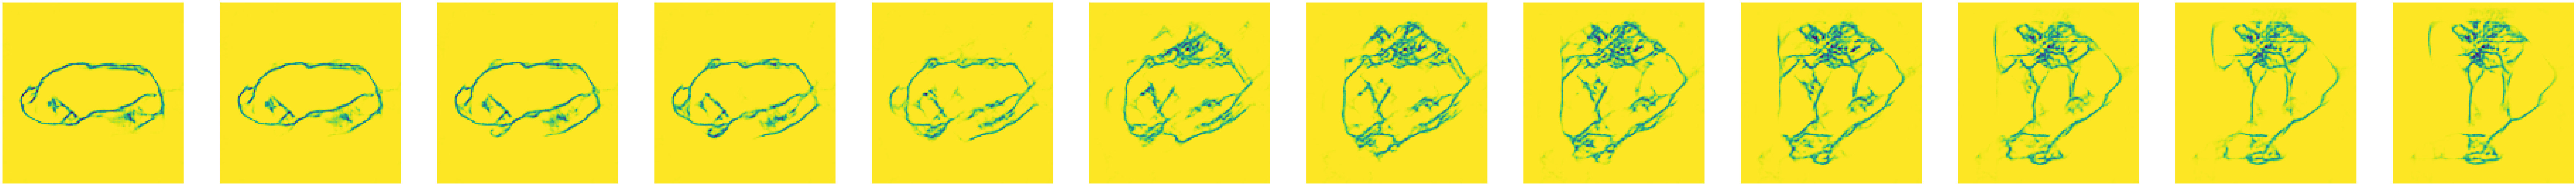

In [6]:
""" # example of interpolating between generated faces
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from PIL import Image
import PIL
from matplotlib.pyplot import imsave
from matplotlib.pyplot import cm
import io


def morphBetweenImages(model, num_of_morphs, latent_space_size):
    # define alpha 
    alpha = np.linspace(0,1,num_of_morphs)
    # get latent spaces
    z1 = np.random.normal(0, 1, size=(1, latent_space_size))
    z2 = np.random.normal(0, 1, size=(1, latent_space_size))
    # morph and plot
    fig = pyplot.figure(figsize=(128,128))
    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = model.predict(z)
        # rescale images
        new_img = 0.5 * (new_img + 1)
        new_img = np.clip(new_img, 0, 1)
        ax = fig.add_subplot(1, num_of_morphs, i+1)
        ax.imshow(new_img.squeeze())
        ax.axis('off')
        #ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))
        fig.savefig(os.path.join("images2/sample_%d.png" % i))
    return

model = load_model('generator.h5')
num_of_morphs = 12
morphBetweenImages(model, num_of_morphs, 100) """

Create morph video of latent space

In [ ]:
""" import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
import argparse
from tqdm import tqdm

im_sz = 1024
mp_sz = 96

warp_scale = 0.05
mult_scale = 0.4
add_scale = 0.4
add_first = False
def warp(origins, targets, preds_org, preds_trg):
    if add_first:
        res_targets = tfa.image.dense_image_warp((origins + preds_org[:,:,:,3:6] * 2 * add_scale) * tf.maximum(0.1, 1 + preds_org[:,:,:,0:3] * mult_scale) , preds_org[:,:,:,6:8] * im_sz * warp_scale )        
        res_origins = tfa.image.dense_image_warp((targets + preds_trg[:,:,:,3:6] * 2 * add_scale) * tf.maximum(0.1, 1 + preds_trg[:,:,:,0:3] * mult_scale) , preds_trg[:,:,:,6:8] * im_sz * warp_scale )
    else:
        res_targets = tfa.image.dense_image_warp(origins * tf.maximum(0.1, 1 + preds_org[:,:,:,0:3] * mult_scale) + preds_org[:,:,:,3:6] * 2 * add_scale, preds_org[:,:,:,6:8] * im_sz * warp_scale )        
        res_origins = tfa.image.dense_image_warp(targets * tf.maximum(0.1, 1 + preds_trg[:,:,:,0:3] * mult_scale) + preds_trg[:,:,:,3:6] * 2 * add_scale, preds_trg[:,:,:,6:8] * im_sz * warp_scale )

    return res_targets, res_origins


def use_warp_maps(origins, targets, fps, steps):
    STEPS = steps
    
    preds = np.load('preds.npy')
    
    #save maps as images
    res_img = np.zeros((im_sz * 2, im_sz * 3, 3))

    res_img[im_sz*0:im_sz*1, im_sz*0:im_sz*1] = preds[0,:,:,0:3] # a_to_b add map
    res_img[im_sz*0:im_sz*1, im_sz*1:im_sz*2] = preds[0,:,:,3:6] # a_to_b mult map
    res_img[im_sz*0:im_sz*1, im_sz*2:im_sz*3, :2] = preds[0,:,:,6:8] # a_to_b warp map
    
    res_img[im_sz*1:im_sz*2, im_sz*0:im_sz*1] = preds[0,:,:,8:11] # b_to_a add map
    res_img[im_sz*1:im_sz*2, im_sz*1:im_sz*2] = preds[0,:,:,11:14] # b_to_a mult map
    res_img[im_sz*1:im_sz*2, im_sz*2:im_sz*3, :2] = preds[0,:,:,14:16] # b_to_a warp map
    
    res_img = np.clip(res_img, -1, 1)
    res_img = ((res_img + 1) * 127.5).astype(np.uint8)
    cv2.imwrite("morph/maps.jpg", cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))
    
    
    #apply maps and save results
    
    org_strength = tf.reshape(tf.range(STEPS, dtype=tf.float32), [STEPS, 1, 1, 1]) / (STEPS - 1) 
    trg_strength = tf.reverse(org_strength, axis = [0])
 
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter('morph/morph.mp4', fourcc, fps, (im_sz, im_sz))
    img_a = np.zeros((im_sz, im_sz * (STEPS // 10), 3), dtype = np.uint8)
    img_b = np.zeros((im_sz, im_sz * (STEPS // 10), 3), dtype = np.uint8)
    img_a_b = np.zeros((im_sz, im_sz * (STEPS // 10), 3), dtype = np.uint8)
    
    res_img = np.zeros((im_sz * 3, im_sz * (STEPS // 10), 3), dtype = np.uint8)
    
    for i in tqdm(range(STEPS)):
        preds_org = preds * org_strength[i]
        preds_trg = preds * trg_strength[i]
    
        res_targets, res_origins = warp(origins, targets, preds_org[...,:8], preds_trg[...,8:])
        res_targets = tf.clip_by_value(res_targets, -1, 1)
        res_origins = tf.clip_by_value(res_origins, -1, 1)
        
        results = res_targets * trg_strength[i] + res_origins * org_strength[i]
        res_numpy = results.numpy()
    
        img = ((res_numpy[0] + 1) * 127.5).astype(np.uint8)
        video.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        if (i+1) % 10 == 0: 
            res_img[im_sz*0:im_sz*1, i // 10 * im_sz : (i // 10 + 1) * im_sz] = img
            res_img[im_sz*1:im_sz*2, i // 10 * im_sz : (i // 10 + 1) * im_sz] = ((res_targets.numpy()[0] + 1) * 127.5).astype(np.uint8)
            res_img[im_sz*2:im_sz*3, i // 10 * im_sz : (i // 10 + 1) * im_sz] = ((res_origins.numpy()[0] + 1) * 127.5).astype(np.uint8)
            
    cv2.imwrite("morph/result.jpg", cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))
    
    cv2.destroyAllWindows()
    video.release()   
    print ('Result video saved.') 
    
 
dom_a = cv2.imread("images/imageg_9999.png", cv2.IMREAD_COLOR)
dom_a = cv2.cvtColor(dom_a, cv2.COLOR_BGR2RGB)
dom_a = cv2.resize(dom_a, (im_sz, im_sz), interpolation = cv2.INTER_AREA)
dom_a = dom_a / 127.5 - 1

dom_b = cv2.imread("images/imageg_0.png", cv2.IMREAD_COLOR)
dom_b = cv2.cvtColor(dom_b, cv2.COLOR_BGR2RGB)
dom_b = cv2.resize(dom_b, (im_sz, im_sz), interpolation = cv2.INTER_AREA)
dom_b = dom_b / 127.5 - 1

origins = dom_a.reshape(1, im_sz, im_sz, 3).astype(np.float32)
targets = dom_b.reshape(1, im_sz, im_sz, 3).astype(np.float32)
use_warp_maps(origins, targets, 18, 100) """